### Import required packages and classes

In [128]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from PID import PIDController
from ot2_gym_wrapper import OT2Env

### Variable Definitions

This cell defines the following variables:
- `INOCULATION_DEPTH` (float): The depth for inoculation, set to -0.3.
- `PLATE_POSITION_ROBOT` (numpy.ndarray): The position of the plate in the robot's coordinate system.
- `PLATE_SIZE_MM` (int): The size of the plate in millimeters, set to 150.
- `PLATE_SIZE_PIXELS` (int): The size of the plate in pixels, set to 2796.
- `PPO` (abc.ABCMeta): The PPO class from the stable_baselines3 library.
- `pid_x`, `pid_y`, `pid_z` (PID.PIDController): PID controllers for the x, y, and z axes respectively.
- `rl_model` (stable_baselines3.ppo.ppo.PPO): The PPO model loaded from a file.

In [129]:
# Initialize controllers
rl_model = PPO.load("model_4096")
pid_x = PIDController(27, 0.5, 2.8, setpoint=1)
pid_y = PIDController(45, 0.1, 2, setpoint=1)
pid_z = PIDController(18, 2.8, 7.8, setpoint=1)

# Define constant
PLATE_SIZE_MM = 150 # define the size of the plate in mm
PLATE_SIZE_PIXELS = 2796 # define the size of the plate in pixels
PLATE_POSITION_ROBOT = np.array([0.10775, 0.088 - 0.026, 0.057]) # define the top-left position of the plate in the robot frame
INOCULATION_DEPTH = -0.3 # define the depth of the needle in the plate

### Conversion Functions

This cell defines the following functions:
- `calculate_conversion_factor(plate_size_mm, plate_size_pixels)`: Calculates the conversion factor from pixels to millimeters based on the plate size.
- `convert_pixel_to_mm(pixel_coords, conversion_factor)`: Converts pixel coordinates to millimeter coordinates using the conversion factor.
- `convert_mm_to_robot_space(root_tip_mm, plate_position_robot)`: Converts millimeter coordinates to the robot's coordinate system by normalizing and adjusting with the plate position.

In [130]:
# define the conversion factor
def calculate_conversion_factor(plate_size_mm, plate_size_pixels):
    return plate_size_mm / plate_size_pixels
# define function to convert pixel coordinates to mm
def convert_pixel_to_mm(pixel_coords, conversion_factor):
    x, y = map(int, pixel_coords.strip("()").split(","))
    return np.array([x, y]) * conversion_factor
# define function to convert mm coordinates to robot space
def convert_mm_to_robot_space(root_tip_mm, plate_position_robot):
    normalized_mm = root_tip_mm / 1000 
    root_tip_mm_with_z = np.append(normalized_mm, [0.171])
    return root_tip_mm_with_z + plate_position_robot

### Goal Position Calculation

This cell defines the following functions:
- `calculate_conversion_factor(plate_size_mm, plate_size_pixels)`: Calculates the conversion factor from pixels to millimeters based on the plate size.
- `convert_pixel_to_mm(pixel_coords, conversion_factor)`: Converts pixel coordinates to millimeter coordinates using the conversion factor.
- `convert_mm_to_robot_space(root_tip_mm, plate_position_robot)`: Converts millimeter coordinates to the robot's coordinate system by normalizing and adjusting with the plate position.

In [131]:
def benchmark_rl_controller(env, goal_positions):
    total_time = 0
    total_accuracy = 0
    accuracy_count = 0

    for i, goal_pos in enumerate(goal_positions, start=1):
        obs, _ = env.reset()
        env.goal_position = goal_pos[:3]
        start_time = time.time()
        distance_errors = []

        while True:
            action, _ = rl_model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, _ = env.step(action)
            distance = np.linalg.norm(goal_pos[:3] - obs[:3])
            distance_errors.append(distance)

            if distance < 0.001 or terminated or truncated:
                break

        time_taken = time.time() - start_time
        total_time += time_taken
        total_accuracy += min(distance_errors)
        accuracy_count += 1

        # Debug print for each goal
        print(f"Goal {i}: Time={time_taken:.2f}s, Accuracy={min(distance_errors):.6f}")

    # Check alignment
    if len(goal_positions) != accuracy_count:
        print(f"Warning: Mismatch in goal_positions ({len(goal_positions)}) and accuracy calculations ({accuracy_count})")

    avg_time = total_time / len(goal_positions)
    avg_accuracy = total_accuracy / len(goal_positions)
    print(f"Total Time={total_time:.2f}s, Total Accuracy={total_accuracy:.6f}")
    print(f"Average Time={avg_time:.2f}s, Average Accuracy={avg_accuracy:.6f}")
    return avg_time, avg_accuracy

# Benchmark PID Controller Function

This function benchmarks a PID controller in a given environment by calculating the average time and accuracy to reach multiple goal positions.

- **Parameters:**
  - `env`: The environment in which the PID controller operates.
  - `goal_positions`: A list of goal positions to reach.

- **Variables:**
  - `total_time`: Accumulates the total time taken to reach all goal positions.
  - `total_accuracy`: Accumulates the minimum distance error for each goal position.

- **Process:**
  1. Iterate over each goal position.
  2. Reset the environment and set the PID controller's setpoints to the current goal position.
  3. Record the start time and initialize a list to store distance errors.
  4. In a loop, update the PID controllers and take a step in the environment.
  5. Calculate the distance to the goal position and append it to the distance errors list.
  6. Break the loop if the distance is less than 0.001 or the episode is terminated or truncated.
  7. Accumulate the total time and the minimum distance error for the current goal position.

- **Return:**
  - The average time and accuracy divided by the number of goal positions.

In [132]:
def benchmark_pid_controller(env, goal_positions):
    # define the variables to store the total time and accuracy
    total_time = 0
    total_accuracy = 0
    # define the loop to iterate over the goal positions
    for i, goal_pos in enumerate(goal_positions, start=1):
        obs, _ = env.reset()
        # set the goal position
        pid_x.setpoint, pid_y.setpoint, pid_z.setpoint = goal_pos
        # define the start time and the distance errors list
        start_time = time.time()
        distance_errors = []

        # define the loop to iterate over the steps
        while True:
            current_position = obs[:3]
            # update the PID controllers
            action_x = pid_x.update(current_position[0], dt=0.05)
            action_y = pid_y.update(current_position[1], dt=0.05)
            action_z = pid_z.update(current_position[2], dt=0.05)
            action = np.array([action_x, action_y, action_z])

            obs, reward, terminated, truncated, _ = env.step(action)
            distance = np.linalg.norm(goal_pos[:3] - obs[:3])
            distance_errors.append(distance)

            # Print the distance to goal position in real-time
            print(f"Goal {i}: Distance to goal = {distance:.6f} meters")

            # check if the distance is less than 0.001 or the episode is terminated or truncated
            if distance < 0.001 or terminated or truncated:
                break

        # calculate the total time and accuracy
        total_time += time.time() - start_time
        total_accuracy += min(distance_errors)
    # return the average time and accuracy divided by the number of goal positions
    return total_time / len(goal_positions), total_accuracy / len(goal_positions)

# Plot Results Function

This function generates a bar plot to compare the average execution time and accuracy of two controllers: a Reinforcement Learning (RL) controller and a PID controller.

- **Parameters:**
  - `rl_avg_time`: Average execution time for the RL controller.
  - `rl_avg_accuracy`: Average accuracy for the RL controller.
  - `pid_avg_time`: Average execution time for the PID controller.
  - `pid_avg_accuracy`: Average accuracy for the PID controller.

- **Process:**
  1. Define the controllers and their corresponding average times and accuracies.
  2. Create subplots with 1 row and 2 columns.
  3. Plot the average execution time on the first subplot:
     - Use a bar plot with different colors for each controller.
     - Set the title, labels, and y-axis limit.
     - Add the values on top of the bars.
  4. Plot the average accuracy on the second subplot:
     - Use a bar plot with different colors for each controller.
     - Set the title, labels, and y-axis limit.
     - Add the values on top of the bars.
  5. Adjust the layout and display the plots.

- **Output:**
  - A bar plot comparing the average execution time and accuracy of the RL and PID controllers.

In [133]:
# define the function to generate the goal positions
def plot_results(rl_avg_time, rl_avg_accuracy, pid_avg_time, pid_avg_accuracy):
    # Create a bar plot to compare the average execution time and accuracy of the two controllers
    controllers = ['RL', 'PID Controller']
    average_time = [rl_avg_time, pid_avg_time]
    average_accuracy = [rl_avg_accuracy, pid_avg_accuracy]

    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot average execution time on the first subplot
    axes[0].bar(controllers, average_time, color=['blue', 'orange'])
    axes[0].set_title('Comparison of Average Execution Time')
    axes[0].set_ylabel('Time (s)')
    axes[0].set_ylim(0, max(average_time) + 0.2)

    # Add values on bars for time
    for i, v in enumerate(average_time):
        axes[0].text(i, v + 0.02, f'{v:.2f} s', ha='center', va='bottom')

    # Plot average accuracy on the second subplot
    axes[1].bar(controllers, average_accuracy, color=['blue', 'orange'])
    axes[1].set_title('Distance from Goal Position')
    axes[1].set_ylabel('Distance (mm)')
    axes[1].set_ylim(0, 1.1)

    # Add values on bars for accuracy
    for i, v in enumerate(average_accuracy):
        axes[1].text(i, v + 0.02, f'{v:.2f} mm', ha='center', va='bottom')

    # Adjust layout and display plots in a single output
    plt.tight_layout()
    plt.show()

# Main Function

This function serves as the entry point for benchmarking and comparing the performance of a Reinforcement Learning (RL) controller and a PID controller in a given environment.

- **Process:**
  1. **Load Environment and Data:**
     - Initialize the environment with rendering enabled.
     - Load root tip data from a CSV file.
  2. **Calculate Conversion Factor:**
     - Calculate the conversion factor between plate size in millimeters and pixels.
  3. **Calculate Goal Positions:**
     - Initialize an empty list for goal positions.
     - Iterate over the root tip data:
       - Convert pixel coordinates to millimeters.
       - Convert millimeter coordinates to robot space.
       - Append the converted coordinates to the goal positions list.
  4. **Benchmark Controllers:**
     - Benchmark the RL controller and store the average time and accuracy.
     - Benchmark the PID controller and store the average time and accuracy.
  5. **Output Results:**
     - Print the average time and accuracy for both controllers.
  6. **Plot Results:**
     - Generate a bar plot to compare the average execution time and accuracy of the two controllers.
  7. **Close Environment:**
     - Close the environment to release resources.

- **Execution:**
  - The main function is executed if the script is run directly.

c:\Users\vl4di\anaconda3\envs\block_b2-gpu\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\vl4di\anaconda3\envs\block_b2-gpu\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Goal 1: Time=0.05s, Accuracy=0.000985
Goal 2: Time=0.05s, Accuracy=0.000964
Goal 3: Time=0.04s, Accuracy=0.000981
Goal 4: Time=0.56s, Accuracy=0.001021
Goal 5: Time=0.03s, Accuracy=0.000976
Goal 6: Time=0.03s, Accuracy=0.000963
Goal 7: Time=0.04s, Accuracy=0.000998
Goal 8: Time=0.12s, Accuracy=0.000974
Goal 9: Time=0.18s, Accuracy=0.000987
Goal 10: Time=0.03s, Accuracy=0.000995
Goal 11: Time=0.04s, Accuracy=0.000928
Goal 12: Time=0.04s, Accuracy=0.000997
Goal 13: Time=0.50s, Accuracy=0.001003
Goal 14: Time=0.53s, Accuracy=0.001081
Goal 15: Time=0.04s, Accuracy=0.000973
Goal 16: Time=0.04s, Accuracy=0.000936
Goal 17: Time=0.05s, Accuracy=0.000973
Goal 18: Time=0.52s, Accuracy=0.001028
Goal 19: Time=0.51s, Accuracy=0.001038
Goal 20: Time=0.04s, Accuracy=0.000950
Goal 21: Time=0.04s, Accuracy=0.000962
Goal 22: Time=0.05s, Accuracy=0.000991
Goal 23: Time=0.50s, Accuracy=0.001023
Goal 24: Time=0.49s, Accuracy=0.001040
Goal 25: Time=0.04s, Accuracy=0.000980
Goal 26: Time=0.04s, Accuracy=0.00

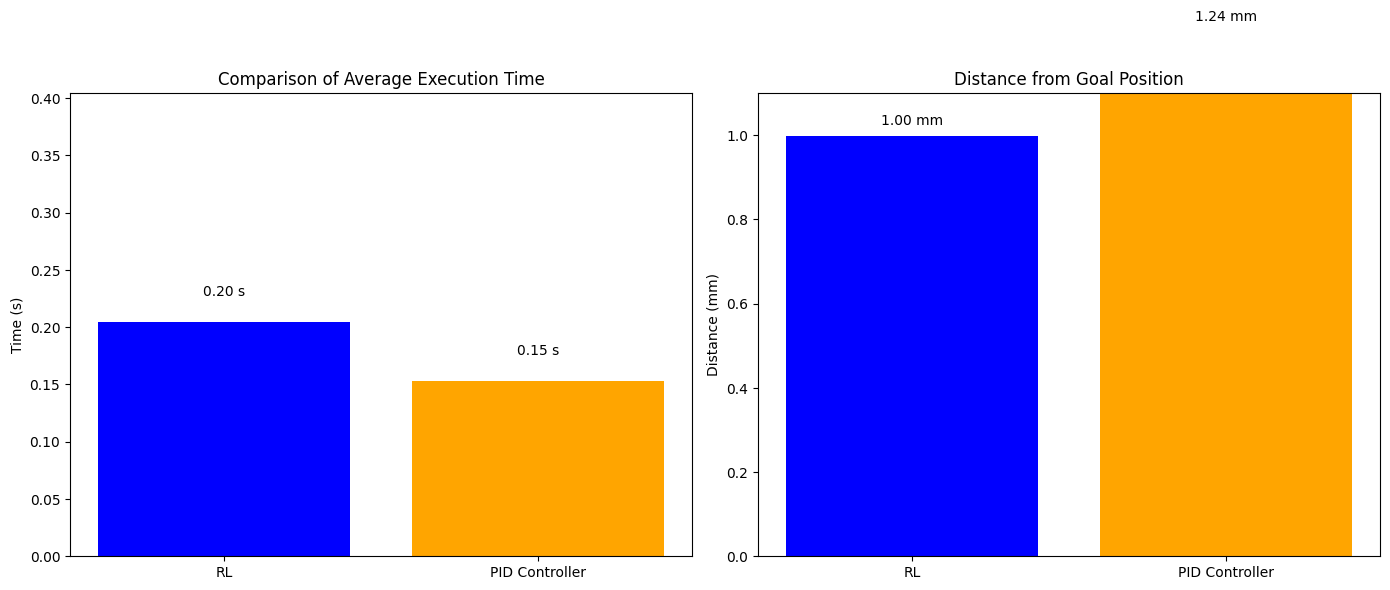

In [134]:
# define the main function
def main():
    # Load environment and goal positions
    env = OT2Env(render=False)
    # Load root tip data
    root_tip_data = pd.read_csv("Root-Tips_plates.csv")
    # Calculate the conversion factor
    conversion_factor = calculate_conversion_factor(PLATE_SIZE_MM, PLATE_SIZE_PIXELS)
    # Calculate the goal positions
    goal_positions = []
    # Iterate over the root tip data
    for _, row in root_tip_data.iterrows():
        if row['Tip (px)'] != "(0, 0)":
            pixel_coords = row['Tip (px)']
            root_tip_mm = convert_pixel_to_mm(pixel_coords, conversion_factor)
            root_tip_robot = convert_mm_to_robot_space(root_tip_mm, PLATE_POSITION_ROBOT)
            goal_positions.append(root_tip_robot)

    # Benchmark both controllers
    rl_avg_time, rl_avg_accuracy = benchmark_rl_controller(env, goal_positions)
    pid_avg_time, pid_avg_accuracy = benchmark_pid_controller(env, goal_positions)

    # Output results
    print(f"RL Controller - Average Time: {rl_avg_time:.2f}s, Average Distance from Goal Position: {rl_avg_accuracy * 1000:.4f}mm")
    print(f"PID Controller - Average Time: {pid_avg_time:.2f}s, Average Distance from Goal Position: {pid_avg_accuracy * 1000:.4f}mm")
    # Plot results
    plot_results(rl_avg_time, rl_avg_accuracy*1000, pid_avg_time, pid_avg_accuracy*1000)

    # Close the environment
    env.close()
# Run the main function
if __name__ == "__main__":
    main()